# Chapter 20: Network-Driven Supervised Machine Learning

## 20.1 The Basics of Supervised Machine Learning

* **Feature**: Inputs designed to make *classes*
* **Classes**: Classifications of things based on input *features*
* **Classifier**: A model that can identify classes based on features
* **Regressor**: A model that predicts numeric values; e.g. the price of a car or house

In [1]:
# Loading iris features and class labels
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
num_classes = len(set(y))
print(f"We have {y.size} labeled examples across the following {num_classes} classes:\n{set(y)}\n")
print(f"First four feature rows:\n{X[:4]}")
print(f"\nFirst four labels:\n{y[:4]}")

We have 150 labeled examples across the following 3 classes:
{0, 1, 2}

First four feature rows:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]]

First four labels:
[0 0 0 0]


In [2]:
# Creating a training set
sampling_size = int(y.size / 4)
X_train, y_train = X[:sampling_size], y[:sampling_size]
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Test Set**: Features and classes outside of our training set; these outputs can be utilized to test the classifier after training

In [3]:
# Creating a training set through random sampling
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(0)

# train_size=0.25 ensures 25% of our total data winds up in the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25) 
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1 2 0]


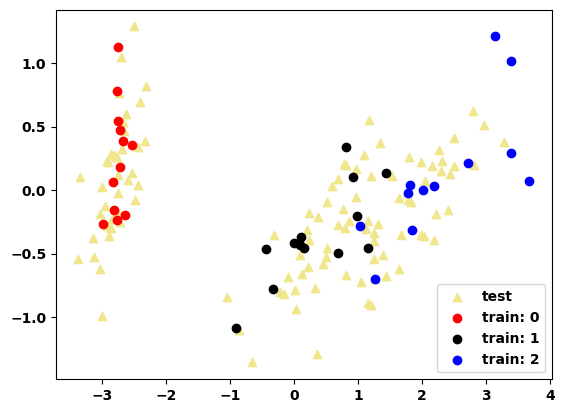

In [4]:
# Plotting the training and test sets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA()
transformed_data_2D = pca_model.fit_transform(X_train)

unlabeled_data = pca_model.transform(X_test)
plt.scatter(unlabeled_data[:,0], unlabeled_data[:,1], color='khaki', marker='^', label='test')

for label in range(3):
    data_subset = transformed_data_2D[y_train == label]
    plt.scatter(data_subset[:,0], data_subset[:,1], color=['r', 'k', 'b'][label], label=f'train: {label}')

plt.legend()
plt.show()

In [5]:
# Computing Euclidean distances between points
from sklearn.metrics.pairwise import euclidean_distances
distance_matrix = euclidean_distances(X_test, X_train)

f_train, f_test = X_test[0], X[0]
distance = distance_matrix[0][0]
print(f"Our fist test set feature is {f_train}")
print(f"Our first training set feature is {f_test}")
print(f"The Euclidean distance between the features is {distance:.2f}")

Our fist test set feature is [5.8 2.8 5.1 2.4]
Our first training set feature is [5.1 3.5 1.4 0.2]
The Euclidean distance between the features is 4.18


**K-nearest Neighbors (KNN)**:  
1. Sort all data points in the training set based on their distance to the unlabeled points   
2. Select the top K-nearest neighbors of the point   
3. Pick the most frequently occurring class across the K neighboring points

In [6]:
# Labeling a point based on its nearest neighbors
from collections import Counter
np.random.seed(6)
random_index = np.random.randint(y_test.size)
labeled_distances = distance_matrix[random_index]
labeled_neighbors = np.argsort(labeled_distances)[:3]
labels = y_train[labeled_neighbors]

top_label, count = Counter(labels).most_common()[0]
print(f"The 3 nearest neighbors of Point {random_index} have the following labels:\n{labels}")
print(f"\nThe most common class label is {top_label}. It occurs {count} times.")

The 3 nearest neighbors of Point 10 have the following labels:
[2 1 2]

The most common class label is 2. It occurs 2 times.


In [7]:
# Checking the true class of a predicted label
true_label = y_test[random_index]
print(f"The true class of Point {random_index} is {true_label}.")

the true class of Point 10 is 2.


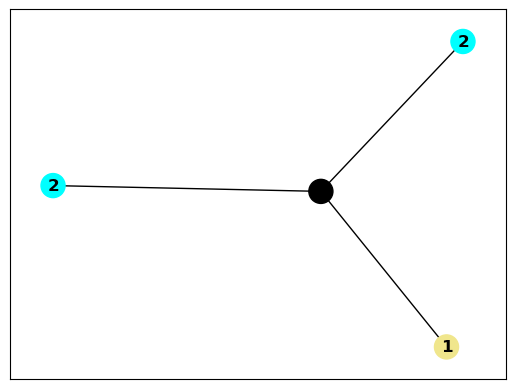

In [8]:
# Visualizing nearest neighbors with NetworkX
import networkx as nx
np.random.seed(0)

def generate_neighbor_graph(unlabeled_index, labeled_neighbors):
    G = nx.Graph()
    nodes = [(i, {'label': y_train[i]}) for i in labeled_neighbors]
    nodes.append((unlabeled_index, {'label': 'U'}))
    G.add_nodes_from(nodes)
    G.add_edges_from([(i, unlabeled_index) for i in labeled_neighbors])
    labels = y_train[labeled_neighbors]
    label_colors = ['pink', 'khaki', 'cyan']
    colors = [label_colors[y_train[i]] for i in labeled_neighbors] + ['k']
    labels = {i: G.nodes[i]['label'] for i in G.nodes}
    nx.draw_networkx(G, node_color=colors, labels=labels, with_labels=True)
    plt.show()
    return G

G = generate_neighbor_graph(random_index, labeled_neighbors)

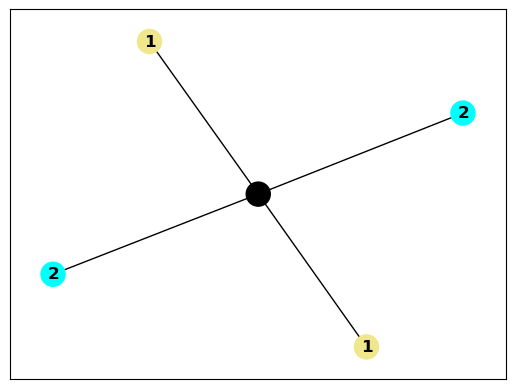

In [9]:
# Increasing the number of nearest neighbors
np.random.seed(0)
labeled_neighbors = np.argsort(labeled_distances)[:4]
G = generate_neighbor_graph(random_index, labeled_neighbors)

In [10]:
# Weighing votes of neighbors based on distance
from collections import defaultdict
class_to_votes = defaultdict(int)
for node in G.neighbors(random_index):
    label = G.nodes[node]['label']
    distance = distance_matrix[random_index][node]
    num_votes = 1 / distance
    print(f"A data point with a label of {label} is {distance:.2f} units away. It recieves {num_votes:.2f} votes.")
    class_to_votes[label] += num_votes

print()
for class_label, votes in class_to_votes.items():
    print(f"We counted {votes:.2f} votes for class {class_label}.")

top_class = max(class_to_votes.items(), key=lambda x: x[1])[0]
print(f"Class {top_class} has received the plurality of the votes.")

A data point with a label of 2 is 0.54 units away. It recieves 1.86 votes.
A data point with a label of 1 is 0.74 units away. It recieves 1.35 votes.
A data point with a label of 2 is 0.77 units away. It recieves 1.29 votes.
A data point with a label of 1 is 0.98 units away. It recieves 1.02 votes.

We counted 3.15 votes for class 2.
We counted 2.36 votes for class 1.
Class 2 has received the plurality of the votes.


## 20.2 Measuring Predicted Label Accuracy